In [95]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [96]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [131]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine, func, text, inspect

In [98]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [99]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

/var/folders/qh/0p4mpg494s79btv7wwxvt2kr0000gn/T/ipykernel_32040/4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [100]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [101]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [102]:
# Create our session (link) from Python to the DB
Session = sessionmaker(bind=engine)
session = Session()

# Exploratory Precipitation Analysis

In [160]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Print the most recent date

print(most_recent_date[0])


2017-08-23


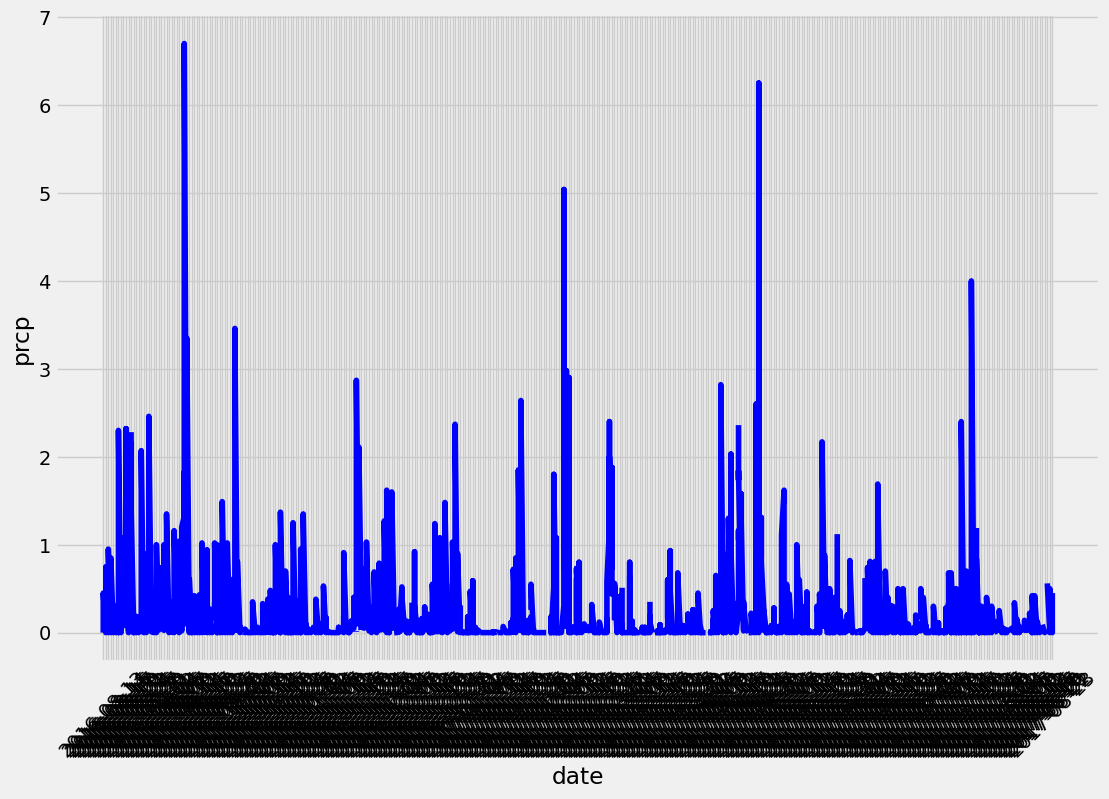

In [182]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_point = session.query(func.max(Measurement.date)).scalar()
# Calculate the date one year from the last date in data set.
year = dt.datetime.strptime(most_recent_point,"%Y-%m-%d") - dt.timedelta(days=375)
year.date()
# Perform a query to retrieve the data and precipitation scores
data_prec_score=session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.asc()).\
        filter(Measurement.date>=year.date()).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
results_pd = pd.DataFrame(data_prec_score)

# Sort the dataframe by date
results_pd.sort_values(by='date', ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(12, 8))
plt.plot(results_pd['date'], results_pd['prcp'], label='Precipitation', color='blue')
plt.xlabel('date')
plt.ylabel('prcp')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [187]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistic = results_pd['prcp'].describe()
summary_statistic_pd = pd.DataFrame(summary_statistic)
summary_statistic_pd

,prcp
count,2080.000000
mean,0.179615
std,0.462017
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [188]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station.station).count()
total_stations


9

In [199]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_active=session.query(Measurement.station,func.count(Measurement.station)).\
                       group_by(Measurement.station).\
                       order_by(func.count(Measurement.station).desc()).all()
station_active



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [208]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp_summany = session.query(func.max(Measurement.tobs),
                            func.min(Measurement.tobs), func.avg(Measurement.tobs)).\
                            filter(Measurement.station==station_active[0][0]).all()
temp_summany

[(85.0, 54.0, 71.66378066378067)]

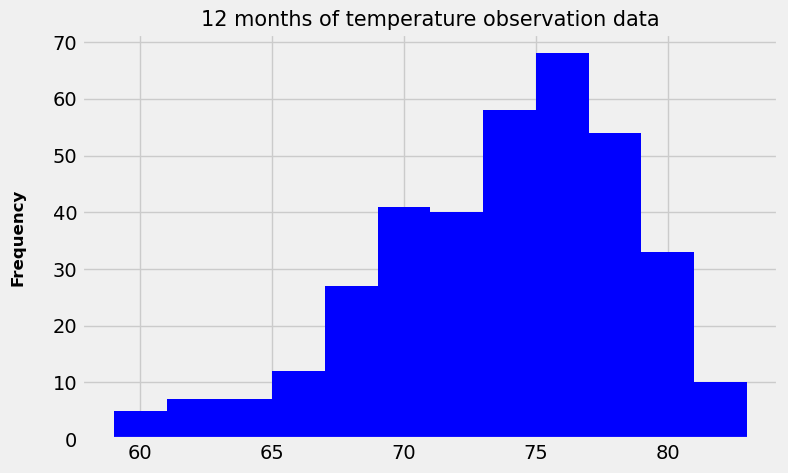

In [224]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station = session.query(Measurement.station,func.count(Measurement.station)).\
                       group_by(Measurement.station).\
                       order_by(func.count(Measurement.station).desc()).first()
most_active_station_first = most_active_station[0]

temp_station = session.query(Measurement.tobs).order_by(Measurement.date.asc()).\
               filter(Measurement.date>=year.date()).\
               filter(Measurement.station == most_active_station_first).all()
temp_station_result = pd.DataFrame(temp_station)

hist_plot = temp_station_result['tobs'].hist(bins=12,figsize=(8,5), color='b', zorder=2)
hist_plot.set_title("12 months of temperature observation data", size=15)
hist_plot.set_ylabel("Frequency", labelpad=20, weight='bold', size=12)

plt.show()

# Close Session

In [16]:
# Close Session
session.close()